# Assignment 6

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

``Objectives``

* This assignment connects all the pieces involved in training feed-forward fully connected neural networks (FFNN); 

* You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for two datasets, and then document your findings.

``Data``
* Digits MNIST
* Fashion MNIST

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from keras.datasets import fashion_mnist
from keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

---
### Step 1: Data ingestion

In [3]:
# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()

# Load the Digits MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()

---
### Step 2: Data preprocessing

``Fashion MNIST``

In [4]:
# Normalize
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

``Digits MNIST``

In [5]:
# Normalize
X_train_digits = X_train_digits / 255.
X_test_digits = X_test_digits / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following task:

1. Show the first training example in X_train_fashion;
2. Show the first training example in X_train_digits;
3. Display the first 5 images in X_train_digits for each class in Y_train_digits, arranged in a 10x5 grid. 

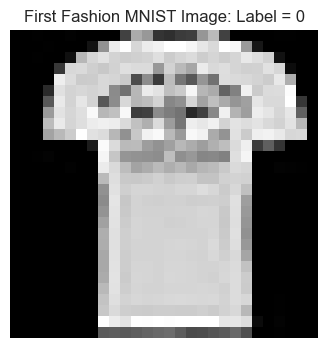

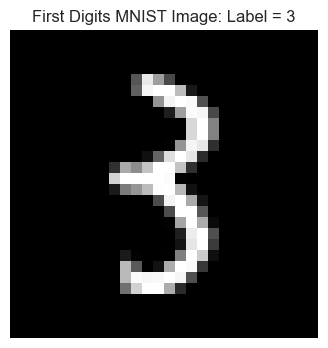

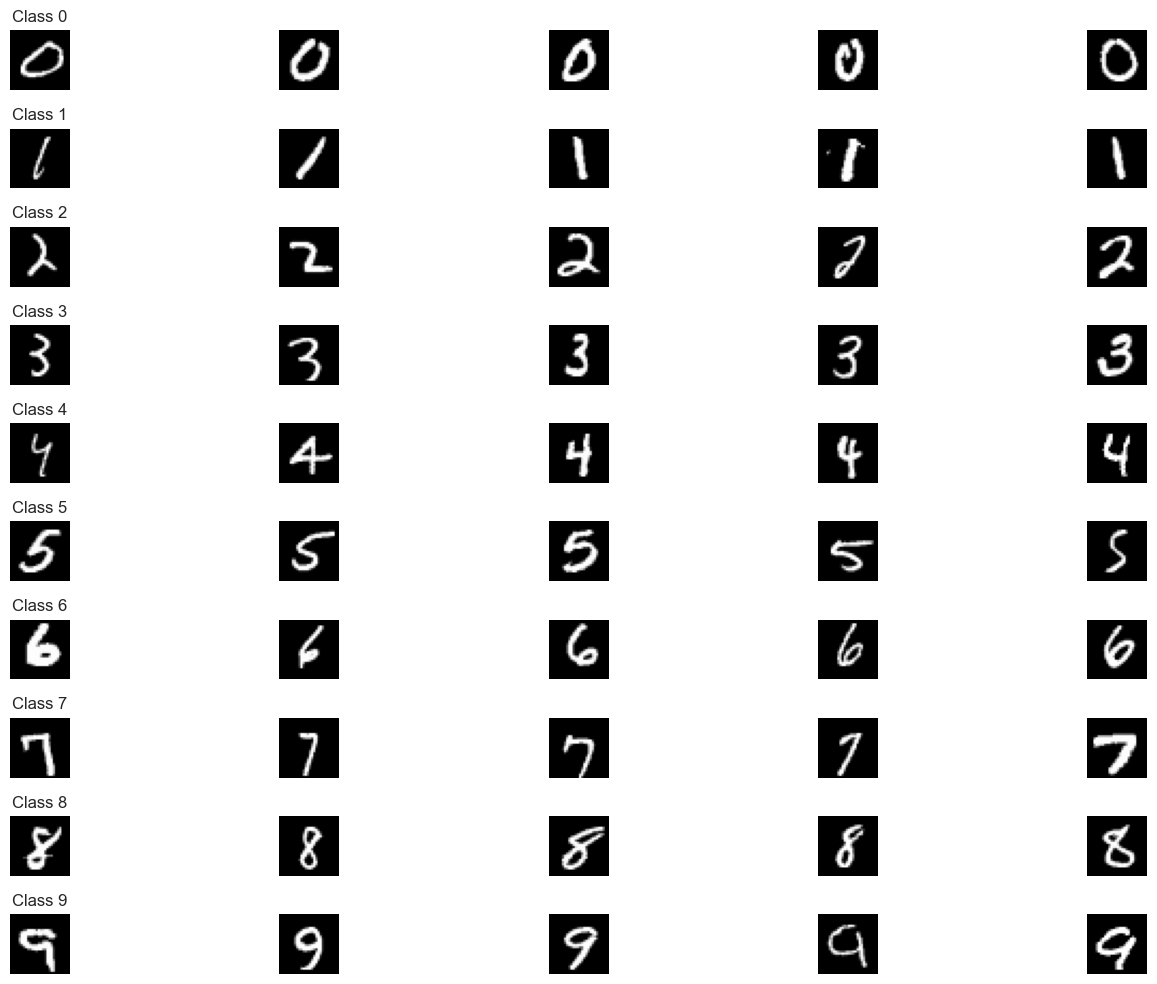

In [6]:
# YOUR CODE HERE
# Task 1: Show the first training example in X_train_fashion
plt.figure(figsize=(4, 4))
plt.imshow(X_train_fashion[0], cmap='gray')
plt.title(f"First Fashion MNIST Image: Label = {Y_train_fashion[0]}")
plt.axis('off')
plt.show()

# Task 2: Show the first training example in X_train_digits
plt.figure(figsize=(4, 4))
plt.imshow(X_train_digits[0], cmap='gray')
plt.title(f"First Digits MNIST Image: Label = {Y_train_digits[0]}")
plt.axis('off')
plt.show()

# Task 3: Display the first 5 images in X_train_digits for each class in Y_train_digits (10x5 grid)
num_classes = 10
num_images_per_class = 5
plt.figure(figsize=(15, 10))

for class_id in range(num_classes):
    # Get the first 'num_images_per_class' indices for each class
    class_indices = np.where(Y_train_digits == class_id)[0][:num_images_per_class]
    for i, idx in enumerate(class_indices):
        plt.subplot(num_classes, num_images_per_class, class_id * num_images_per_class + i + 1)
        plt.imshow(X_train_digits[idx], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f"Class {class_id}")

plt.tight_layout()
plt.show()

### Step 4: Modeling

### <span style="color:chocolate">Exercise 2:</span> Define model (20 points)

1. Fill in the <span style="color:chocolate">build_model()</span> function below, including all the arguments listed in the function definition. Note: the activation function parameter is only for the the hidden layers; use the appropriate final classification function for the final layer.

In [15]:
from tensorflow.keras import layers, models, optimizers

def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
    # Initialize the Sequential model
    model = models.Sequential()

    # Flatten the input for fully connected layers
    model.add(layers.Flatten(input_shape=(28, 28)))  # assuming 28x28 input images (for MNIST datasets)

    # Add hidden layers based on the hidden_layer_sizes list
    for layer_size in hidden_layer_sizes:
        model.add(layers.Dense(layer_size, activation=activation))

    # Add the output layer with 'n_classes' units and softmax activation for multi-class classification
    model.add(layers.Dense(n_classes, activation='softmax'))

    # Choose the optimizer
    if optimizer == 'SGD':
        opt = optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Use 'SGD' or 'Adam'.")

    # Compile the model
    model.compile(optimizer=opt, 
                  loss='sparse_categorical_crossentropy',  # suitable for multi-class classification
                  metrics=[metric])

    return model

---
### Step 5: Experiments

You can now run a suite of experiments to see how the hyperparameters and layer sizes effect model performance. 

The <span style="color:chocolate">train_and_evaluate()</span> function below can be used to run experiments and retrieve results.

c:\Users\myk53\hello\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the digits model...


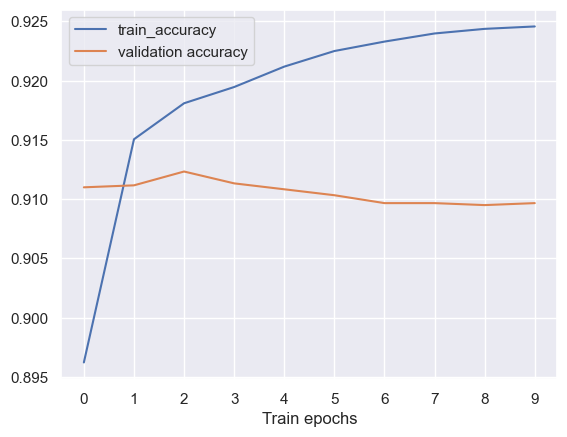

Training accuracy: 0.9246
Validation accuracy: 0.9097


In [16]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model.
    model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)

  # Select the dataset.
    if data == 'digits':
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits
    
    elif data == 'fashion':
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model


# run the function
model = train_and_evaluate()

### <span style="color:chocolate">Exercise 3:</span> Ablation study (50 points)

1. Conduct experiments and record the training and validation set accuracy results in the table below. You may extend the table for additional experiments as needed.
2. Report the hyperparameter values for your preferred architecture configuration.
3. Run the model once more using your preferred hyperparameter configuration.

Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 digits | [] | tanh | SGD |0.01| 7850 | |
 digits | [] | relu | SGD |0.01| 7850 | |
 digits | [] | relu | Adam |0.01| 7850 | |
 digits | [128] | relu | Adam |0.01| 101770 | |
 digits | [256, 128] | relu | Adam |0.01| 235146 | |
-|-|-|-|-|-|-|-
 fashion | [] | tanh | SGD |0.01| 7850 | |
 fashion | [] | relu | SGD |0.01| 7850 | |
 fashion | [] | relu | Adam |0.01| 7850 | |
 fashion | [128] | relu | Adam |0.01| 101770 | |
 fashion | [256, 128] | relu | Adam |0.01| 235146 | |

c:\Users\myk53\hello\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the digits model...


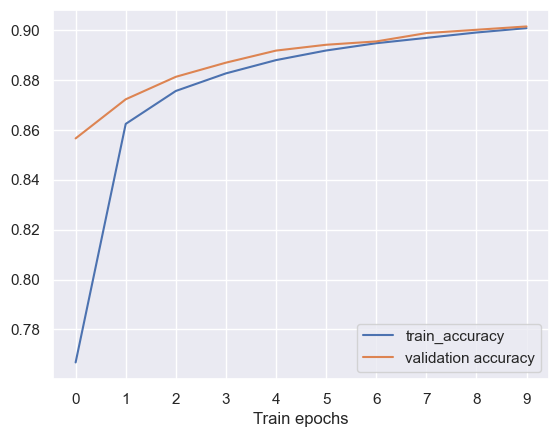

Training accuracy: 0.9007
Validation accuracy: 0.9013
Training the digits model...


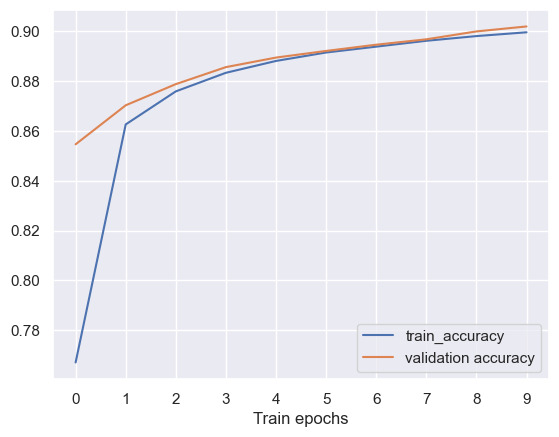

Training accuracy: 0.8996
Validation accuracy: 0.9020
Training the digits model...


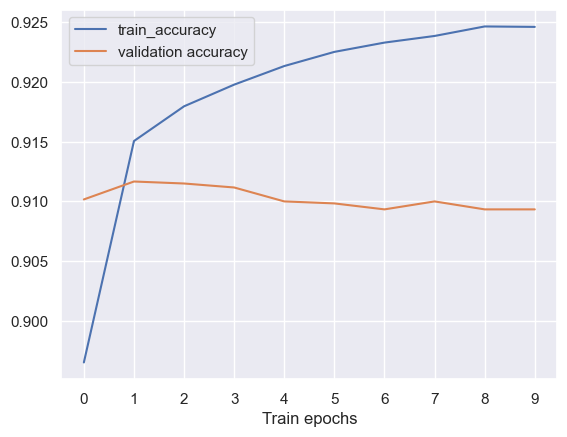

Training accuracy: 0.9246
Validation accuracy: 0.9093
Training the digits model...


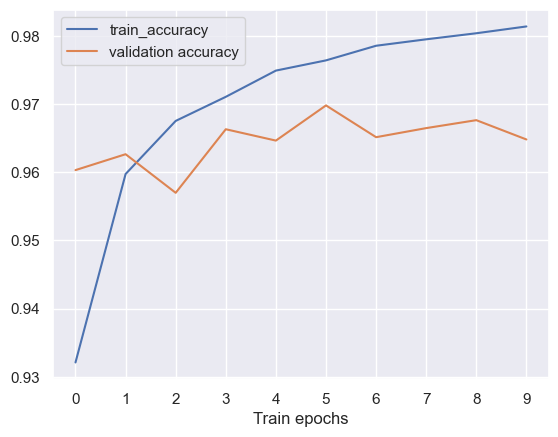

Training accuracy: 0.9814
Validation accuracy: 0.9648
Training the digits model...


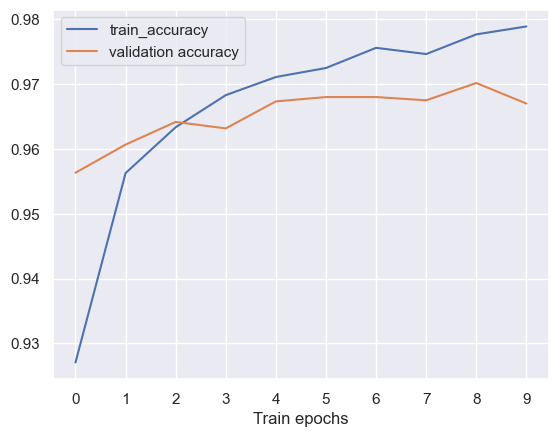

Training accuracy: 0.9789
Validation accuracy: 0.9670
Training the fashion model...


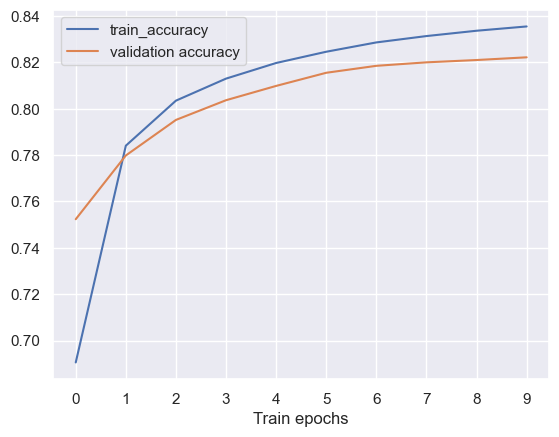

Training accuracy: 0.8355
Validation accuracy: 0.8222
Training the fashion model...


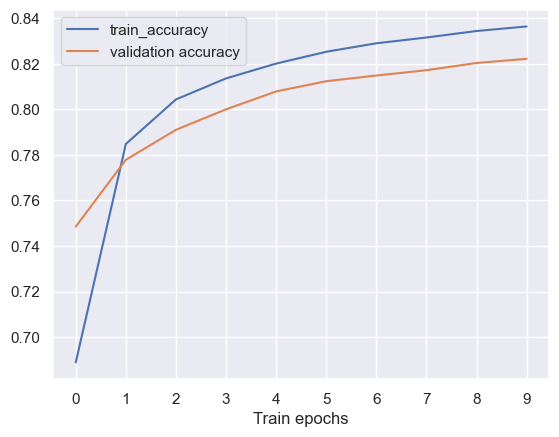

Training accuracy: 0.8364
Validation accuracy: 0.8222
Training the fashion model...


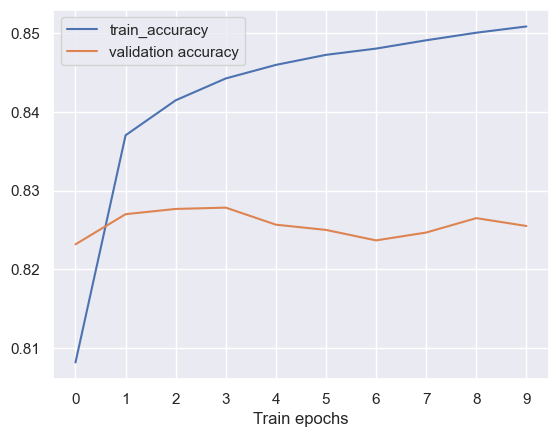

Training accuracy: 0.8509
Validation accuracy: 0.8255
Training the fashion model...


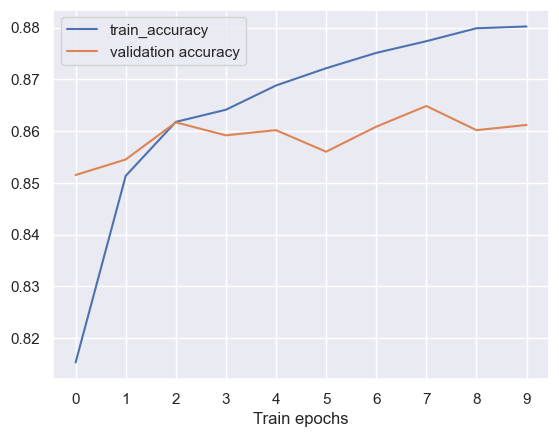

Training accuracy: 0.8802
Validation accuracy: 0.8612
Training the fashion model...


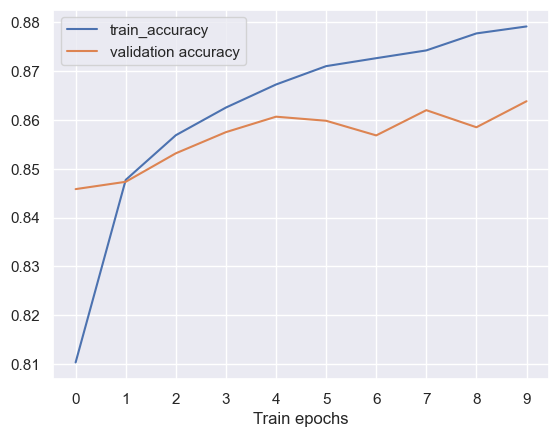

Training accuracy: 0.8791
Validation accuracy: 0.8638
      Data Hidden sizes Activation Optimizer  Learning rate  #Parameters  \
0   digits           []       tanh       SGD           0.01         7850   
1   digits           []       relu       SGD           0.01         7850   
2   digits           []       relu      Adam           0.01         7850   
3   digits        [128]       relu      Adam           0.01       101770   
4   digits   [256, 128]       relu      Adam           0.01       235146   
5  fashion           []       tanh       SGD           0.01         7850   
6  fashion           []       relu       SGD           0.01         7850   
7  fashion           []       relu      Adam           0.01         7850   
8  fashion        [128]       relu      Adam           0.01       101770   
9  fashion   [256, 128]       relu      Adam           0.01       235146   

   Training accuracy  Validation accuracy  
0           0.900667             0.901333  
1           0.899648 

In [19]:
# YOUR CODE HERE
# Define function for Ablation Study
def run_experiment_and_record(data, hidden_sizes, activation, optimizer, learning_rate, num_epochs=10):
    model = train_and_evaluate(data=data,
                               hidden_layer_sizes=hidden_sizes,
                               activation=activation,
                               optimizer=optimizer,
                               learning_rate=learning_rate,
                               num_epochs=num_epochs)
    return model.count_params(), model.history.history['accuracy'][-1], model.history.history['val_accuracy'][-1]

# Create a table to store results
import pandas as pd

results = []

# Experiments for Digits Dataset
results.append(('digits', [], 'tanh', 'SGD', 0.01, *run_experiment_and_record('digits', [], 'tanh', 'SGD', 0.01)))
results.append(('digits', [], 'relu', 'SGD', 0.01, *run_experiment_and_record('digits', [], 'relu', 'SGD', 0.01)))
results.append(('digits', [], 'relu', 'Adam', 0.01, *run_experiment_and_record('digits', [], 'relu', 'Adam', 0.01)))
results.append(('digits', [128], 'relu', 'Adam', 0.01, *run_experiment_and_record('digits', [128], 'relu', 'Adam', 0.01)))
results.append(('digits', [256, 128], 'relu', 'Adam', 0.01, *run_experiment_and_record('digits', [256, 128], 'relu', 'Adam', 0.01)))

# Experiments for Fashion Dataset
results.append(('fashion', [], 'tanh', 'SGD', 0.01, *run_experiment_and_record('fashion', [], 'tanh', 'SGD', 0.01)))
results.append(('fashion', [], 'relu', 'SGD', 0.01, *run_experiment_and_record('fashion', [], 'relu', 'SGD', 0.01)))
results.append(('fashion', [], 'relu', 'Adam', 0.01, *run_experiment_and_record('fashion', [], 'relu', 'Adam', 0.01)))
results.append(('fashion', [128], 'relu', 'Adam', 0.01, *run_experiment_and_record('fashion', [128], 'relu', 'Adam', 0.01)))
results.append(('fashion', [256, 128], 'relu', 'Adam', 0.01, *run_experiment_and_record('fashion', [256, 128], 'relu', 'Adam', 0.01)))

# Convert results to a DataFrame for visualization
results_df = pd.DataFrame(results, columns=['Data', 'Hidden sizes', 'Activation', 'Optimizer', 'Learning rate', '#Parameters', 'Training accuracy', 'Validation accuracy'])

print(results_df)

---
### Step 6: Evaluation and Generalization

### <span style="color:chocolate">Exercise 4:</span> Compute metrics (25 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras and the <span style="color:chocolate">np.max()</span> method available in NumPy; or you can use the <span style="color:chocolate">model.evaluare()</span> method provided by tf.keras directly.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your accuracy observations.

In [21]:
# YOUR CODE HERE
def compute_metrics(model, X_train, Y_train, X_test, Y_test):
    """
    Compute and display the accuracy on both train and test datasets.
    
    Args:
    model: Trained Keras model
    X_train: Training data (features)
    Y_train: Training labels
    X_test: Test data (features)
    Y_test: Test labels
    
    Returns:
    None
    """
    # Training Accuracy
    train_loss, train_accuracy = model.evaluate(X_train, Y_train, verbose=0)
    print(f"Training Accuracy: {train_accuracy:.4f}")
    
    # Test Accuracy
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Predict on Test Data and convert probabilities to class labels
    Y_pred_probs = model.predict(X_test)
    Y_pred = np.argmax(Y_pred_probs, axis=1)
    
    # Alternatively, you can use test_accuracy directly from model.evaluate(), but here's the manual way to compute it
    manual_test_accuracy = np.mean(Y_pred == Y_test)
    print(f"Manual Test Accuracy: {manual_test_accuracy:.4f}")

# Assuming the best model is stored in 'model'
# Use X_train_digits/Y_train_digits or X_train_fashion/Y_train_fashion depending on your dataset choice

# Example using Digits dataset
compute_metrics(model, X_train_digits, Y_train_digits, X_test_digits, Y_test_digits)

# Example using Fashion dataset
# compute_metrics(model, X_train_fashion, Y_train_fashion, X_test_fashion, Y_test_fashion)


Training Accuracy: 0.9230
Test Accuracy: 0.9133
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
Manual Test Accuracy: 0.9133


Answer: the difference between the training accuracy (92.30%) and the test accuracy (91.33%) is minimal, with a gap of only 0.97%. This small gap suggests that the model is not overfitting, meaning it performs almost equally well on both the training and unseen test data.